<center><h2> Inpainting Sparse EPIs with Shearlets </h2></center>

In [62]:
using PyPlot
using Shearlab

In [6]:
n =512;

In [7]:
# The path of the sparse EPI
name_sparse = "../Diagrams/results/new_EPIs/104_8_102_7_12_3_sparse.png";
EPI_sparse = Shearlab.load_image(name_sparse, n);
EPI_sparse = EPI_sparse[:,:,1];

In [8]:
m = size(EPI_sparse)[2]

689

In [9]:
name_dense = "../Diagrams/results/new_EPIs/104_8_102_7_12_3_dense.png";
EPI_dense = Shearlab.load_image(name_dense, n,m);
EPI_dense = EPI_dense[:,:,1];

### Lets design the mask.

In [10]:
#Initialize with ones 
mask = ones(Float64,size(EPI_dense));

In [11]:
mask[abs.(EPI_dense-EPI_sparse).!=0]=0

0

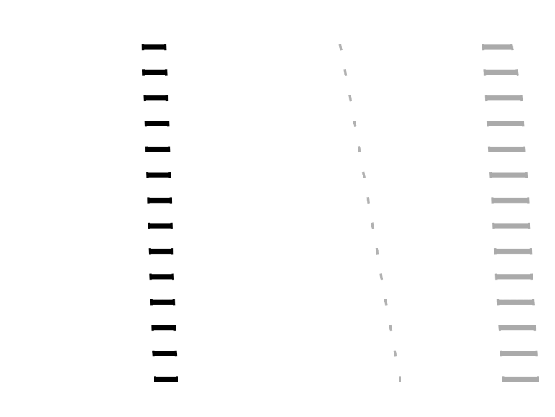

In [12]:
Shearlab.imageplot(EPI_sparse)

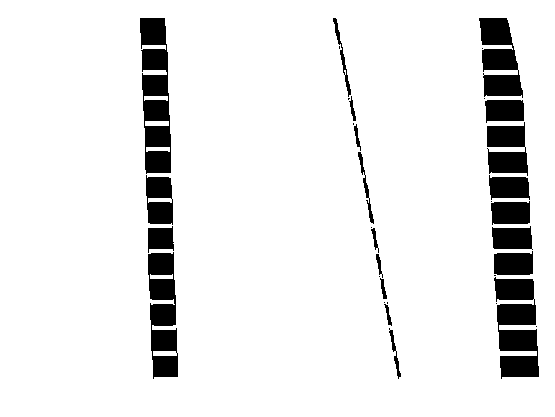

In [13]:
Shearlab.imageplot(mask)

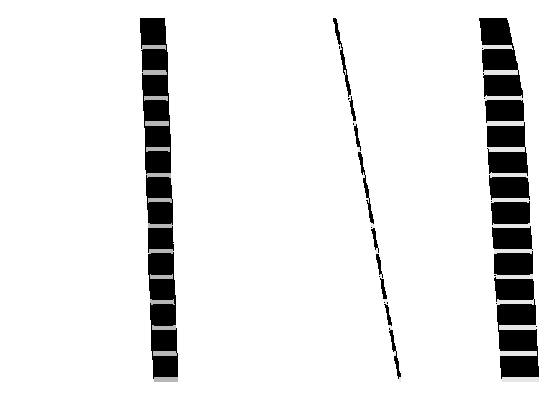

In [14]:
Shearlab.imageplot(EPI_sparse.*mask)

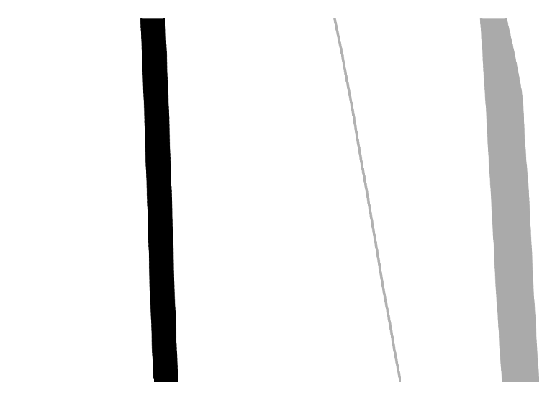

In [15]:
Shearlab.imageplot(EPI_dense)

### Inpainting

In [16]:
# Data 
EPI_masked = EPI_sparse.*mask;
stopFactor = 0.005; # The highest coefficient times stopFactor
sizeX = size(EPI_masked,1);
sizeY = size(EPI_masked,2);
dmax = 7; # Disparity term
nScales = convert(Int,ceil(log(2,dmax)));

In [17]:
#shearLevels |k|<= 2^(j+1)+1
shearLevels = [2.0^(j+1)+1 for j in 0:(nScales-1)];

In [21]:
shearLevels = shearLevels'

1×3 Array{Float64,2}:
 3.0  5.0  9.0

In [23]:
tic()
shearletsystem = Shearlab.getshearletsystem2D(sizeX, sizeY, nScales);
toc()

elapsed time: 19.607510218 seconds


19.607510218

#### Normalized iterative thresholding

In [24]:
function inpaint2D(imgMasked,mask,iterations,stopFactor,shearletsystem)
    coeffs = Shearlab.sheardec2D(imgMasked,shearletsystem);
    coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
    for i in 1:shearletsystem.nShearlets
        coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
    end
    delta = maximum(abs(coeffsNormalized[:]));
    lambda=(stopFactor)^(1/(iterations-1));
    imgInpainted = zeros(size(imgMasked));
    #iterative thresholding
    for it = 1:iterations
        res = mask.*(imgMasked-imgInpainted);
        coeffs = Shearlab.sheardec2D(imgInpainted+res,shearletsystem);
        coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
        for i in 1:shearletsystem.nShearlets
            coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
        end
        coeffs = coeffs.*(abs(coeffsNormalized).>delta);
        imgInpainted = Shearlab.shearrec2D(coeffs,shearletsystem);  
        delta=delta*lambda;  
    end
    imgInpainted
end

inpaint2D (generic function with 1 method)

<b>Normalized iterative thresholding with varying acceleration</b>.

In [25]:
function inpaint2D_accel(imgMasked,mask,iterations,stopFactor,shearletsystem)
    coeffs = Shearlab.sheardec2D(imgMasked,shearletsystem);
    coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
    for i in 1:shearletsystem.nShearlets
        coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
    end
    delta = maximum(abs(coeffsNormalized[:]));
    lambda=(stopFactor)^(1/(iterations-1));
    imgInpainted = zeros(size(imgMasked));
    alpha = 1
    #iterative thresholding
    for it = 1:iterations
        res = mask.*(imgMasked-imgInpainted);
        coeffs = Shearlab.sheardec2D(imgInpainted+alpha*res,shearletsystem);
        coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
        for i in 1:shearletsystem.nShearlets
            coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
        end
        coeffs = coeffs.*(abs(coeffsNormalized).>delta);
        # Support of coeffsNormalized until 
        norms = [norm(coeffs[:,:,i]) for i in 1:size(coeffs)[3]]
        # Thresholding the norm of the matrices to catch the support (smallest )
        indices = (norms.<0.5)
        beta = Shearlab.sheardec2D(res,shearletsystem);
        beta[(~indices)...] = 0;
        beta2 = mask.*(Shearlab.shearrec2D(beta,shearletsystem));
        alpha = sum((abs.(beta)).^2)/sum((abs.(beta2)).^2)
        imgInpainted = Shearlab.shearrec2D(coeffs,shearletsystem);  
        delta=delta*lambda;  
    end
    imgInpainted
end

inpaint2D_accel (generic function with 1 method)

### Iterations

In [37]:
tic()
EPIinpainted50 = inpaint2D(EPI_masked,mask,50,stopFactor,shearletsystem);
toc()

elapsed time: 194.006890415 seconds


194.006890415

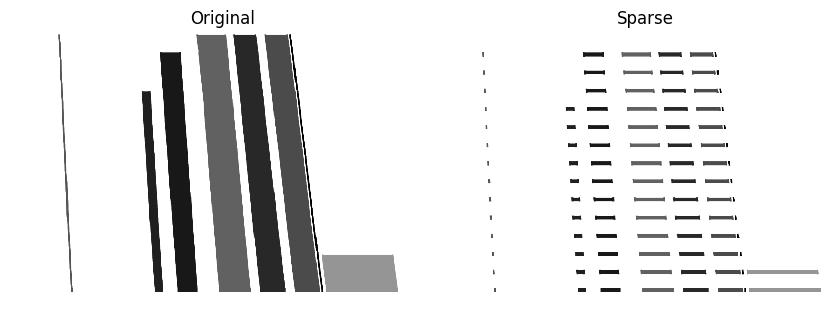

In [17]:
clf;
figure(figsize=(10,10));
Shearlab.imageplot(EPI_dense, "Original", 1,2,1); 
Shearlab.imageplot(EPI_sparse, "Sparse", 1,2,2); 

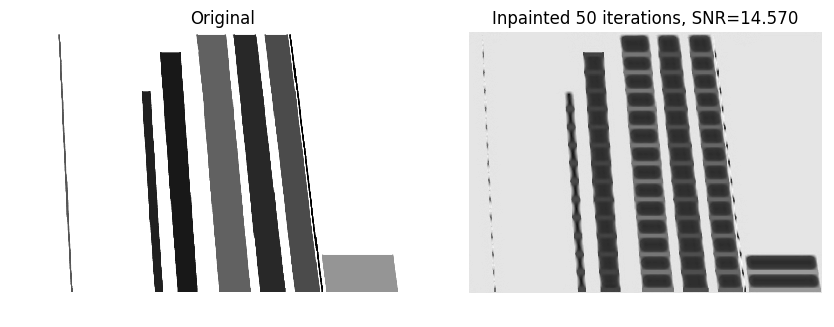

In [39]:
elin = Shearlab.snr(EPI_dense,EPIinpainted50);
# display
clf;
figure(figsize=(10,10));
Shearlab.imageplot(EPI_dense, "Original", 1,2,1); 
u = @sprintf("Inpainted 50 iterations, SNR=%.3f", elin);
Shearlab.imageplot(real(EPIinpainted50), u, 1,2,2);

##### Saving the inpainted image

In [145]:
name_inpainted1 = split(name_dense,"/")
name_inpainted1[4] = "Inpainted"
last_name = name_inpainted1[5]
last_name_split = split(last_name,"_")
last_name_split[7] = "inpainted.png"
last_name_split
last_name = last_name_split[1]
for i in 2:size(last_name_split)[1]
    last_name = last_name*"_"*last_name_split[i]
end
name_inpainted1[5] = last_name
name_inpainted = name_inpainted1[1]
for i in 2:size(name_inpainted1)[1]
    name_inpainted = name_inpainted*"/"*name_inpainted1[i]
end
name_inpainted

"../Diagrams/results/Inpainted/680_6_102_7_34_8_inpainted.png"

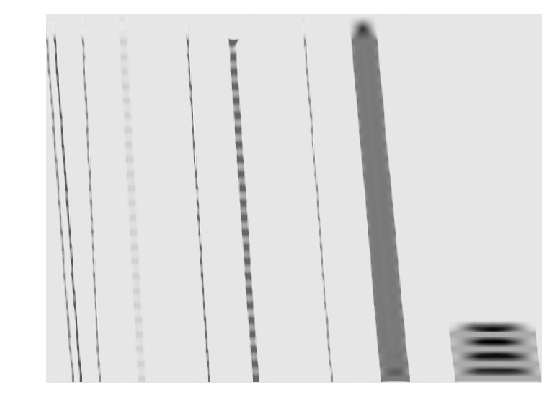

In [312]:
Shearlab.imageplot(real(EPIinpainted50))
savefig(name_inpainted, dpi = 80*3,bbox_inches="tight")

### Inpainting the list

In [43]:
split_list(string)=split(string,"_")
list_files = readdir("../Diagrams/results/EPIs/");
list_files = list_files[2:length(list_files)]
sparse_list = [];
dense_list = [];

In [46]:
for string in list_files
    if split(string,"_")[7]=="sparse.png"
        push!(sparse_list,string)
    end
end

In [47]:
for string in list_files
    if split(string,"_")[7]=="dense.png"
        push!(dense_list,string)
    end
end

In [52]:
file_sparse = sparse_list[1];
file_dense = dense_list[1];

In [53]:
# The path of the sparse EPI
name_sparse = "../Diagrams/results/EPIs/"*file_sparse;
EPI_sparse = Shearlab.load_image(name_sparse, n,m);
EPI_sparse = EPI_sparse[:,:,1];
name_dense = "../Diagrams/results/EPIs/"*file_dense;
EPI_dense = Shearlab.load_image(name_dense, n,m);
EPI_dense = EPI_dense[:,:,1];
#Initialize with ones 
mask = ones(Float64,size(EPI_dense));
mask[abs.(EPI_dense-EPI_sparse).!=0]=0
# Data 
EPI_masked = EPI_sparse.*mask;
stopFactor = 0.005; # The highest coefficient times stopFactor
sizeX = size(EPI_masked,1);
sizeY = size(EPI_masked,2);
dmax = 7; # Disparity term
nScales = convert(Int,ceil(log(2,dmax)));
#shearLevels |k|<= 2^(j+1)+1
shearLevels = [2.0^(j+1)+1 for j in 0:(nScales-1)];

In [55]:
tic()
shearletsystem = Shearlab.getshearletsystem2D(sizeX, sizeY, nScales);
toc()

elapsed time: 20.09519431 seconds


20.09519431

In [56]:
function inpaint_file(file_sparse,file_dense) 
    # The path of the sparse EPI
    name_sparse = "../Diagrams/results/EPIs/"*file_sparse;
    EPI_sparse = Shearlab.load_image(name_sparse, n,m);
    EPI_sparse = EPI_sparse[:,:,1];
    name_dense = "../Diagrams/results/EPIs/"*file_dense;
    EPI_dense = Shearlab.load_image(name_dense, n,m);
    EPI_dense = EPI_dense[:,:,1];
    #Initialize with ones 
    mask = ones(Float64,size(EPI_dense));
    mask[abs.(EPI_dense-EPI_sparse).!=0]=0
    # Data 
    EPI_masked = EPI_sparse.*mask;
    stopFactor = 0.005; # The highest coefficient times stopFactor
    EPIinpainted50 = inpaint2D(EPI_masked,mask,50,stopFactor,shearletsystem);
    name_inpainted1 = split(name_dense,"/")
    name_inpainted1[4] = "Inpainted"
    last_name = name_inpainted1[5]
    last_name_split = split(last_name,"_")
    last_name_split[7] = "inpainted.png"
    last_name_split
    last_name = last_name_split[1]
    for i in 2:size(last_name_split)[1]
        last_name = last_name*"_"*last_name_split[i]
    end
    name_inpainted1[5] = last_name
    name_inpainted = name_inpainted1[1]
    for i in 2:size(name_inpainted1)[1]
        name_inpainted = name_inpainted*"/"*name_inpainted1[i]
    end
    name_inpainted
    Shearlab.imageplot(real(EPIinpainted50))
    savefig(name_inpainted, dpi = 80*3,bbox_inches="tight")
    clf()
end

inpaint_file (generic function with 1 method)

In [57]:
file_sparse = sparse_list[10];
file_dense = dense_list[10];

In [58]:
i = 10
file_sparse = sparse_list[i];
file_dense = dense_list[i];
inpaint_file(file_sparse,file_dense);

In [61]:
for i in 1:length(sparse_list)
    file_sparse = sparse_list[i];
    file_dense = dense_list[i];
    inpaint_file(file_sparse,file_dense);
end